## Classifiers for Voter Information
In this notebook, we build different classifiers and measure their performance.

In [1]:
"""Import dataset"""
import pandas as pd
df = pd.DataFrame.from_csv('../Data/Dataset2016.csv')
df.describe()

,per_capita_income,population_density,pop_without_a2i,urban_pop_density,rural_pop_density,gt_50_internet,median_dl_speed,median_ul_speed,upper_quartile_dl,upper_quartile_ul,lower_quartile_dl,lower_quartile_ul
count,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000
mean,24006.278018,238.861244,35.600931,1388.975954,38.393421,0.975391,5.198062,1.997164,8.941998,3.325612,2.961012,1.223224
std,5613.751160,1807.759865,32.114530,1983.974369,41.611166,0.154957,4.325171,2.192160,7.227155,3.672943,3.213946,1.649285
min,8200.000000,0.066000,0.000000,0.000000,0.000000,0.000000,0.000980,0.002930,0.000980,0.002930,0.000980,0.002930
25%,20264.000000,15.460500,8.000000,812.023500,8.665500,1.000000,2.158480,0.595222,3.613796,0.839778,1.115677,0.387398
50%,23378.000000,43.756000,26.000000,1396.950000,25.708000,1.000000,3.979200,1.230833,7.033845,2.107423,2.070695,0.696388
75%,26715.500000,112.236500,56.000000,1863.025000,53.539500,1.000000,7.096713,2.690522,12.235057,4.610483,3.563242,1.412133
max,63610.000000,73077.080000,100.000000,73077.080000,679.088000,1.000000,52.043947,26.558962,70.893460,57.350828,51.639653,23.235680


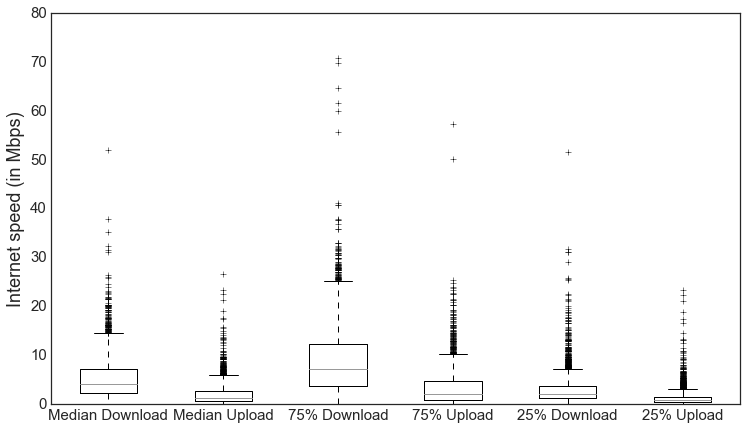

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(11, 7))
plt.style.use(['grayscale', 'seaborn-white'])
df2 = df[['median_dl_speed', 'median_ul_speed', 'upper_quartile_dl', 'upper_quartile_ul', 
          'lower_quartile_dl', 'lower_quartile_ul']]
df2.columns = ['Median Download', 'Median Upload', '75% Download', '75% Upload', '25% Download', '25% Upload']
ax.set_ylabel('Internet speed (in Mbps)')
axes, lines = df2.boxplot(fontsize=15, return_type='both', grid=False, ax=ax)

In [3]:
"""Create two datasets from the csv file - one with all features, and the other with reduced features"""
import numpy as np
from collections import Counter

dataset = df.iloc[:, :].as_matrix()

# X_full has all features
X_full = dataset[:, :-1]

# X_reduced has features related to Internet speeds only
X_reduced = dataset[:, [2, 5, 6, 7, 8, 9, 10, 11]]

# Extract the labels
Y_labels = dataset[:, -1]

# Hack for one missing label, currently coding it as 0
Y = np.zeros(len(Y_labels))
for i in range(len(Y_labels)):
    if Y_labels[i] != 'None':
        Y[i] = int(Y_labels[i])
  
print("Full dataset shape:", X_full.shape)
print("Reduced dataset shape:", X_reduced.shape)
print("Labels shape:", Y.shape)
print("Class distribution:",Counter(Y))

Full dataset shape: (3007, 12)
Reduced dataset shape: (3007, 8)
Labels shape: (3007,)
Class distribution: Counter({1.0: 2558, 0.0: 449})


In [4]:
"""Random sampling to balance the dataset"""
import random

# Set seed to a fixed value for reproducibility 
random.seed(42)

X_full_sample = []
X_reduced_sample = []
Y_sample = []

# The threshold decides whether an entry should be included in the sampled dataset or not
threshold = 0.2

for i in range(len(Y)):
    if Y[i] == 0:
        X_full_sample.append(X_full[i])
        X_reduced_sample.append(X_reduced[i])
        Y_sample.append(Y[i])
    elif random.random() < threshold:
        X_full_sample.append(X_full[i])
        X_reduced_sample.append(X_reduced[i])
        Y_sample.append(Y[i])

X_full_sample = np.array(X_full_sample)
X_reduced_sample = np.array(X_reduced_sample)
Y_sample = np.array(Y_sample)

print("Sampled dataset size:", X_full_sample.shape, X_reduced_sample.shape)
print("Sampled labels size:", Y_sample.shape)
print("Class distribution after sampling:", Counter(Y_sample))

Sampled dataset size: (930, 12) (930, 8)
Sampled labels size: (930,)
Class distribution after sampling: Counter({1.0: 481, 0.0: 449})


In [5]:
"""Preprocess the dataset and divide it into train and test"""
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Standardize the datasets
scaler_f = StandardScaler().fit(X_full_sample)
scaler_r = StandardScaler().fit(X_reduced_sample)

X_train_f, X_test_f, y_train, y_test = train_test_split(scaler_f.transform(X_full_sample), 
                                                        Y_sample, test_size=0.2, random_state=42)
X_train_r, X_test_r, y_train, y_test = train_test_split(scaler_r.transform(X_reduced_sample), 
                                                        Y_sample, test_size=0.2, random_state=42)

print("Class distribution in training and testing set:", Counter(y_train), Counter(y_test))

Class distribution in training and testing set: Counter({1.0: 394, 0.0: 350}) Counter({0.0: 99, 1.0: 87})


/Users/ashish/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

lr_model_f = LogisticRegressionCV(cv=10)
lr_model_f.fit(X_train_f, y_train)

lr_model_r = LogisticRegressionCV(cv=10)
lr_model_r.fit(X_train_r, y_train)

y_pred_f = lr_model_f.predict(X_test_f)
y_pred_r = lr_model_r.predict(X_test_r)

print("Full Dataset::Train Set::Accuracy score:", accuracy_score(y_train, lr_model_f.predict(X_train_f)))
print("Full Dataset::Test Set::Accuracy score:", accuracy_score(y_test, y_pred_f))

print("Reduced Dataset::Train Set::Accuracy score:", accuracy_score(y_train, lr_model_r.predict(X_train_r)))
print("Reduced Dataset::Test Set::Accuracy score:", accuracy_score(y_test, y_pred_r))

Full Dataset::Train Set::Accuracy score: 0.721774193548
Full Dataset::Test Set::Accuracy score: 0.698924731183
Reduced Dataset::Train Set::Accuracy score: 0.686827956989
Reduced Dataset::Test Set::Accuracy score: 0.698924731183


In [7]:
"""Print model coefficients"""
print(y_pred_f)

np.set_printoptions(linewidth=120)

print("Full Dataset::Coefficients")
print(lr_model_f.coef_)
print()
print("Reduced Dataset::Coefficients")
print(lr_model_r.coef_)

[ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  0.  0.  1.
  0.  0.  1.  1.  1.  1.  1.  0.  0.  1.  1.  0.  1.  0.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  1.  0.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.
  0.  1.  0.  1.  1.  0.  1.  1.  0.  1.  0.  1.  1.  1.  0.  1.  1.  1.
  0.  1.  0.  0.  1.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.
  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  1.  1.  0.  1.  0.  0.  1.
  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  1.  0.  0.  1.
  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  0.  0.  1.  1.  0.  0.
  1.  1.  0.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  0.  1.  1.  1.
  1.  1.  1.  0.  0.  0.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  1.]
Full Dataset::Coefficients
[[  0.23997571 -10.83883401   0.10919426  -0.85401388   0.39154203   0.18329974  -0.08159512   0.06604114  -0.30217106
   -0.07256847   0.38693257  -0.06649829]]

Reduced Dataset::Coefficients
[[ 0.28310402  0.1769378

Reduced Dataset::Train Set::Accuracy score: 0.686827956989
Reduced Dataset::Test Set::Accuracy score: 0.709677419355
[[ 0.12180012  0.09367462  0.04182929  0.02232382 -0.38600541 -0.04496146  0.23179387 -0.04989751]]


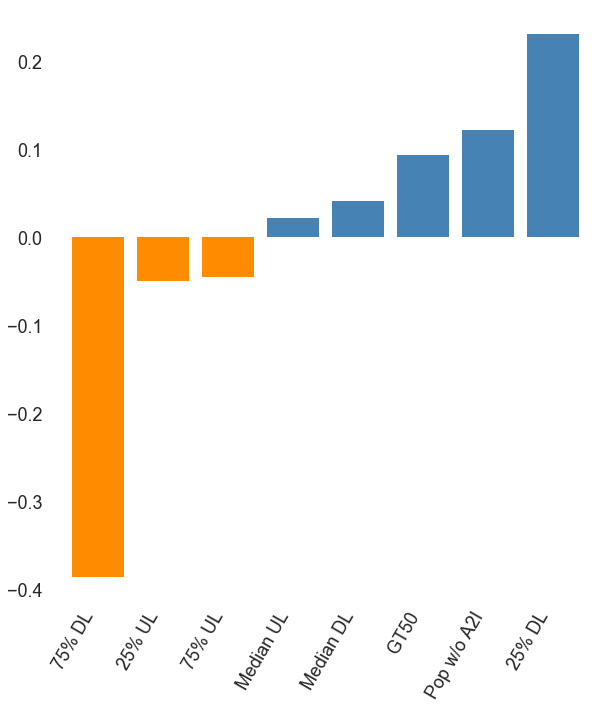

In [42]:
"""Support vector machine"""
from sklearn.svm import LinearSVC
import matplotlib as mpl

mpl.rcParams['axes.facecolor'] = 'ffffff'
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)

svm = LinearSVC()
svm.fit(X_train_r, y_train)
y_pred_svm = svm.predict(X_test_r)
print("Reduced Dataset::Train Set::Accuracy score:", accuracy_score(y_train, svm.predict(X_train_r)))
print("Reduced Dataset::Test Set::Accuracy score:", accuracy_score(y_test, y_pred_svm))

print(svm.coef_)

coef = svm.coef_.ravel()
top_features = 3
top_positive_coefficients = np.argsort(coef)[-5:]
top_negative_coefficients = np.argsort(coef)[:3]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
plt.figure(figsize=(10, 11))
colors = ['#FF8C00' if c < 0 else '#4682B4' for c in coef[top_coefficients]]
plt.bar(np.arange(8), coef[top_coefficients], color=colors)
feature_names = ['Pop w/o A2I', 'GT50', 'Median DL', 'Median UL', '75% DL', '75% UL', '25% DL', '25% UL']
feature_names = np.array(feature_names)
plt.xticks(np.arange(0, 1 + 2 * 4 - 1), feature_names[top_coefficients], rotation=60, ha='right')
plt.savefig('../SVMOutput.png')

### Tree Classifiers
We run the same tests with a DecisionTreeClassifier and a RandomForestClassifier

In [8]:
"""From here onwards, we run our tests on reduced dataset only because the test accuracy is the same"""
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

X_train = X_train_r
X_test = X_test_r

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)
y_pred_rfc = rfc.predict(X_test)

print("DecisionTreeClassifier::Accuracy Score:", accuracy_score(y_test, y_pred_dtc))
print("RandomForestClassifier::Accuracy Score:", accuracy_score(y_test, y_pred_rfc))

DecisionTreeClassifier::Accuracy Score: 0.596774193548
RandomForestClassifier::Accuracy Score: 0.634408602151


### Quick check on Performance
Looks like Logistic Regression is already performing better than Tree Classifiers. To evaluate why this is the case, take a look at the confusion matrix for each of the models.

In [35]:
"""Confusion matrix for Logistic Regression"""
from sklearn.metrics import confusion_matrix
print("Logistic Regression")
print(confusion_matrix(y_test, y_pred_f))

Logistic Regression
[[54 45]
 [11 76]]


In [37]:
"""Metrics"""
from sklearn.metrics import classification_report
print(accuracy_score(y_test, y_pred_r))
print(accuracy_score(y_test, y_pred_f))
print(classification_report(y_test, y_pred_r))
print(classification_report(y_test, y_pred_f))

0.698924731183
0.698924731183
             precision    recall  f1-score   support

        0.0       0.76      0.64      0.69        99
        1.0       0.65      0.77      0.71        87

avg / total       0.71      0.70      0.70       186

             precision    recall  f1-score   support

        0.0       0.83      0.55      0.66        99
        1.0       0.63      0.87      0.73        87

avg / total       0.74      0.70      0.69       186



In [10]:
print("Random Forest Classifier")
print(confusion_matrix(y_test, y_pred_rfc))

Random Forest Classifier
[[63 36]
 [32 55]]


In [11]:
print("Decision Tree Classifier")
print(confusion_matrix(y_test, y_pred_dtc))

Decision Tree Classifier
[[58 41]
 [34 53]]


In [12]:
"""Quick look at the r2 score"""
from sklearn.metrics import r2_score
print("Logistic Regresion::R2 Score:", r2_score(y_test, y_pred_r))
print("Decision Tree Classifier::R2 Score:", r2_score(y_test, y_pred_dtc))
print("Random Forest Classifier::R2 Score:", r2_score(y_test, y_pred_rfc))

Logistic Regresion::R2 Score: -0.209334726576
Decision Tree Classifier::R2 Score: -0.490073145246
Random Forest Classifier::R2 Score: -0.382096830373


## Notes
The logistic regression model still reports a negative R2 value, which means it is a poor fit for the data. Yet, it is able to get an almost 70% accuracy.

#### Doing a quick MDS plot of the data to visualize the variability in the data

In [12]:
from sklearn.manifold import MDS

mds_model = MDS(n_init=10, verbose=1)
mds_model.fit(X_train)
embeddings = mds_model.embedding_

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

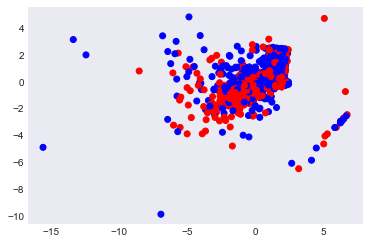

In [14]:
colors = ['r' if i == 0 else 'b' for i in y_train]
plt.scatter(embeddings[:,0], embeddings[:,1], color=colors)

## Visualizing Results
Bar chart for visualizing weights of the model.

In [15]:
import seaborn as sns
sns.set_style('whitegrid')

In [16]:
print("Header values: ", df.columns.values[[2, 5, 6, 7, 8, 9, 10, 11]])

Header values:  ['pop_without_a2i' 'gt_50_internet' 'median_dl_speed' 'median_ul_speed' 'upper_quartile_dl' 'upper_quartile_ul'
 'lower_quartile_dl' 'lower_quartile_ul']


In [17]:
header_values = ['Population without A2I', 'Internet availability (50% or greater)', 
                 'Median D/L Speed', 'Median U/L Speed', 'Upper Quartile D/L speed', 
                 'Upper Quartile U/L speed', 'Lower Quartile D/L speed', 'Lower Quartile U/L speed']
data = pd.DataFrame(columns=header_values, data=np.array(lr_model_r.coef_))

In [18]:
tips = sns.load_dataset("tips")
print(tips)

     total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
5         25.29  4.71    Male     No   Sun  Dinner     4
6          8.77  2.00    Male     No   Sun  Dinner     2
7         26.88  3.12    Male     No   Sun  Dinner     4
8         15.04  1.96    Male     No   Sun  Dinner     2
9         14.78  3.23    Male     No   Sun  Dinner     2
10        10.27  1.71    Male     No   Sun  Dinner     2
11        35.26  5.00  Female     No   Sun  Dinner     4
12        15.42  1.57    Male     No   Sun  Dinner     2
13        18.43  3.00    Male     No   Sun  Dinner     4
14        14.83  3.02  Female     No   Sun  Dinner     2
15        21.58  3.92    Male     No   Sun  Dinner     2
16        10.33  1.67  Female  

In [19]:
"""Import dataset"""
import pandas as pd
df = pd.DataFrame.from_csv('../Data/Dataset2016-RepublicanPercentage.csv')
df.describe()

,per_capita_income,population_density,pop_without_a2i,urban_pop_density,rural_pop_density,gt_50_internet,median_dl_speed,median_ul_speed,upper_quartile_dl,upper_quartile_ul,lower_quartile_dl,lower_quartile_ul
count,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000
mean,24006.278018,238.861244,35.600931,1388.975954,38.393421,0.975391,5.198062,1.997164,8.941998,3.325612,2.961012,1.223224
std,5613.751160,1807.759865,32.114530,1983.974369,41.611166,0.154957,4.325171,2.192160,7.227155,3.672943,3.213946,1.649285
min,8200.000000,0.066000,0.000000,0.000000,0.000000,0.000000,0.000980,0.002930,0.000980,0.002930,0.000980,0.002930
25%,20264.000000,15.460500,8.000000,812.023500,8.665500,1.000000,2.158480,0.595222,3.613796,0.839778,1.115677,0.387398
50%,23378.000000,43.756000,26.000000,1396.950000,25.708000,1.000000,3.979200,1.230833,7.033845,2.107423,2.070695,0.696388
75%,26715.500000,112.236500,56.000000,1863.025000,53.539500,1.000000,7.096713,2.690522,12.235057,4.610483,3.563242,1.412133
max,63610.000000,73077.080000,100.000000,73077.080000,679.088000,1.000000,52.043947,26.558962,70.893460,57.350828,51.639653,23.235680


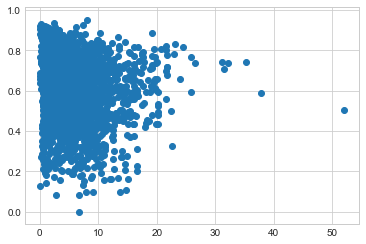

In [33]:
dataset_percentage = df.iloc[:, :].as_matrix()
median_dl_speed = dataset[:, 6]
lower_dl_speed = dataset[:, 10]
percentage = []
for i in dataset_percentage[:, -1]:
    if i == 'None' or i is None:
        percentage.append(0)
    else:
        percentage.append(float(i))

plt.scatter(median_dl_speed, percentage)

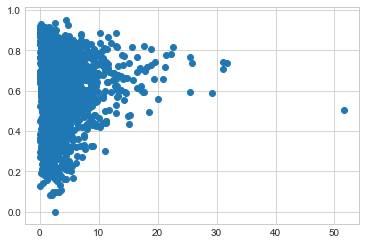

In [34]:
plt.scatter(lower_dl_speed, percentage)

In [44]:
df1 = pd.DataFrame.from_csv('../Data/Dataset2016.csv')
df2 = pd.DataFrame.from_csv('../Data/CountyProviderStatistics.csv')
df3 = df1.join(df2)
df3 = df3.drop(['countyId', 'geographyId', 'geographyName'], axis=1)
X = df3.loc[:, df3.columns != 'party_won']
y = df3.loc[:, 'party_won']

In [46]:
print(X.columns)

Index(['per_capita_income', 'population_density', 'pop_without_a2i',
       'urban_pop_density', 'rural_pop_density', 'gt_50_internet',
       'median_dl_speed', 'median_ul_speed', 'upper_quartile_dl',
       'upper_quartile_ul',
       ...
       'wirelineUploadSpeedGreaterThan10000k',
       'wirelineUploadSpeedGreaterThan1500k',
       'wirelineUploadSpeedGreaterThan1Gig',
       'wirelineUploadSpeedGreaterThan200k',
       'wirelineUploadSpeedGreaterThan25000k',
       'wirelineUploadSpeedGreaterThan3000k',
       'wirelineUploadSpeedGreaterThan50000k',
       'wirelineUploadSpeedGreaterThan6000k',
       'wirelineUploadSpeedGreaterThan768k',
       'wirelineUploadSpeedLessThan200k'],
      dtype='object', length=129)


In [47]:
X = X.as_matrix()
y = y.as_matrix()

Y = np.zeros(y.shape)
for i in range(len(y)):
    if y[i] != 'None':
        Y[i] = float(y[i])
    else:
        Y[i] = 0.0
print(X.shape, X.dtype)
print(Y.shape, Y.dtype)

(3014, 129) float64
(3014,) float64


In [50]:
X_sample = []
Y_sample = []

random.seed(42)

# The threshold decides whether an entry should be included in the sampled dataset or not
threshold = 0.2

for i in range(len(Y)):
    if Y[i] == 0:
        X_sample.append(X[i])
        Y_sample.append(Y[i])
    elif random.random() < threshold:
        X_sample.append(X[i])
        Y_sample.append(Y[i])

X_sample = np.array(X_sample)
Y_sample = np.array(Y_sample)

print("Sampled dataset size:", X_sample.shape)
print("Sampled labels size:", Y_sample.shape)
print("Class distribution after sampling:", Counter(Y_sample))

Sampled dataset size: (933, 129)
Sampled labels size: (933,)
Class distribution after sampling: Counter({1.0: 481, 0.0: 452})


In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Standardize the datasets
scaler = StandardScaler().fit(X_sample)

X_train, X_test, y_train, y_test = train_test_split(scaler.transform(X_sample), 
                                                        Y_sample, test_size=0.2, random_state=42)

print("Class distribution in training and testing set:", Counter(y_train), Counter(y_test))

Class distribution in training and testing set: Counter({1.0: 392, 0.0: 354}) Counter({0.0: 98, 1.0: 89})


In [53]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
clf = LassoCV()
sfm = SelectFromModel(clf)
sfm.fit(X_train, y_train)
n_features = sfm.transform(X_train).shape[1]
print(n_features)

/Users/ashish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


42


In [59]:
selected_features = df3.loc[:, df3.columns != 'party_won'].columns[sfm.get_support()]
print(selected_features)

Index(['per_capita_income', 'urban_pop_density', 'rural_pop_density',
       'gt_50_internet', 'upper_quartile_dl', 'upper_quartile_ul',
       'lower_quartile_dl', 'asymmetricDsl', 'cableOther', 'copper',
       'downloadSpeedGt25000kAndLt50000k', 'downloadSpeedGt768kAndLt1500k',
       'downloadSpeedLessThan3Mbps', 'fiberTechnology',
       'fixedWirelessLicensed', 'fixedWirelessUnlicensed',
       'greatestUploadSpeedPercentage', 'mostCommonDownloadSpeed',
       'mostCommonDownloadSpeedPercentage', 'mostCommonUploadSpeed',
       'mostCommonUploadSpeedPercentage', 'numberOfWirelessProvidersEquals0',
       'numberOfWirelessProvidersEquals2', 'numberOfWirelessProvidersEquals4',
       'numberOfWirelessProvidersEquals7',
       'numberOfWirelessProvidersGreaterThan8',
       'numberOfWirelineProvidersEquals1', 'numberOfWirelineProvidersEquals4',
       'numberOfWirelineProvidersEquals5', 'uploadSpeedGt100000kAndLt1Gig',
       'uploadSpeedGt200kAndLt768k', 'uploadSpeedGt768kAndLt1500

In [60]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(cv=10)
model.fit(sfm.transform(X_train), y_train)
y_pred = model.predict(sfm.transform(X_test))
print(accuracy_score(y_test, y_pred))
print(model.coef_)

0.705882352941
[[ 0.01408462 -0.11668089 -0.00733171  0.09866158 -0.1430646  -0.09241915  0.11415187 -0.08876946 -0.08391244
  -0.18049682  0.03877025 -0.04969887 -0.04084893  0.05250131 -0.00628666  0.12158603  0.07231592  0.0371446  -0.12470298
   0.04946808 -0.07745016 -0.04748307  0.04265021 -0.11354171  0.04333589  0.06808571  0.11743839 -0.12914844
  -0.06495585 -0.0647665  -0.03716633 -0.06886471 -0.06001265 -0.06994922 -0.0182997   0.03193316 -0.0182997  -0.10220533
  -0.12661673 -0.07369412 -0.10539952 -0.09091443]]


In [61]:
svm = LinearSVC()
svm.fit(sfm.transform(X_train), y_train)
y_pred = svm.predict(sfm.transform(X_test))
print(accuracy_score(y_test, y_pred))

0.663101604278


In [62]:
print(selected_features[0])

per_capita_income


In [63]:
with open('../Visualizations/data.csv', 'w') as fwriter:
    fwriter.write('name,value\n')
    for name, value in zip(selected_features, model.coef_[0]):
        fwriter.write('%s,%s\n' % (name, value))

In [64]:
with open('../Visualizations/data-svm.csv', 'w') as fwriter:
    fwriter.write('name,value\n')
    for name, value in zip(selected_features, svm.coef_[0]):
        fwriter.write('%s,%s\n' % (name, value))